In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, DetCurveDisplay, accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

In [3]:
train = np.loadtxt('Synthetic data/train.txt', delimiter = ',')
dev = np.loadtxt('Synthetic data/dev.txt', delimiter = ',')

classes = {1: 0, 2: 1}

In [4]:
X_train, y_train = train[:, :2], train[:, 2]
X_dev, y_dev = dev[:, :2], dev[:, 2]

In [5]:
train_true = pd.Series([classes[i] for i in y_train])
dev_true = pd.Series([classes[i] for i in y_dev])

In [40]:
def knn_predict(X_train, y_train, X_test, classes, k = 10):
    m = X_train.shape[0]
    n = X_test.shape[0]
    ref = range(m)
    scores = np.zeros((n, len(classes)))
    for i in range(n):
        test = X_test[i, :]
        score = np.sum((X_train - test)**2, axis = -1)
        sort_idx = sorted(ref, key = lambda x: score[x])[:k]
        for idx in sort_idx:
            scores[i, classes[y_train[idx]]] += 1
    return scores/k

In [5]:
scores_dev = knn_predict(X_train, y_train, X_dev, classes, k = 1)

In [6]:
dev_pred = np.argmax(scores_dev, axis = -1)

In [39]:
def evaluate_classifier(y, scores, thresh = 0.5):
    enc = OneHotEncoder()
    y_sparse = enc.fit_transform(y.to_numpy().reshape(-1, 1)).toarray()
    prob = scores/np.sum(scores, axis = -1)[:, np.newaxis]
    n, c = prob.shape
    cm = np.zeros((2, 2))
    for i in range(c):
        col = []
        for j in range(y.shape[0]):
            if prob[j, i] >= thresh:
                col.append(1)
            else:
                col.append(0)
        cm += confusion_matrix(y_sparse[:, i], col)
    tpr = cm[1, 1]/(cm[1, 1] + cm[1, 0])
    fpr = cm[0, 1]/(cm[0, 1] + cm[0, 0])
    return tpr, fpr, cm

def compute_ROC(y, scores, h = 0.05):
    threshold = [i*h for i in range(int(1/h + 1))]
    tpr, fpr = [], []
    for thresh in threshold:
        a, b, _ = evaluate_classifier(y, scores, thresh = thresh)
        tpr.append(a)
        fpr.append(b)
    return tpr, fpr, threshold

def compute_DET(y, scores, h = 0.05):
    threshold = [i*h for i in range(int(1/h + 1))]
    fpr, fnr = [], []
    for thresh in threshold:
        _, b, cm = evaluate_classifier(y, scores, thresh = thresh)
        fpr.append(b)
        fnr.append(cm[1, 0]/(cm[1, 0] + cm[1, 1]))
    return fpr, fnr, threshold

def plot_confusion_matrix(y, pred, classes, title = 'Development Set'):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(5, 4))
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y, pred), annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix - ' + title, fontsize=20)
    plt.show()

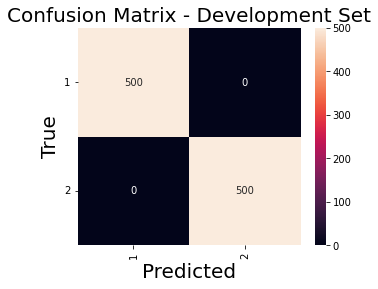

In [8]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [9]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


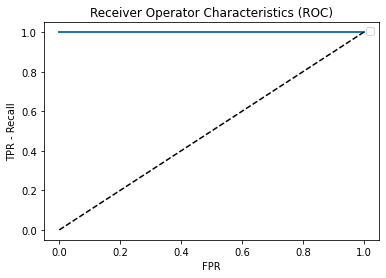

In [10]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

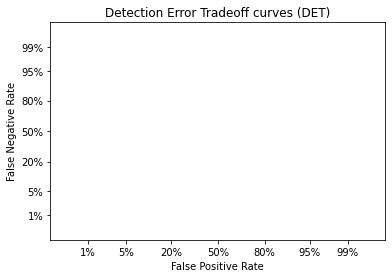

In [11]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()

In [14]:
acc = []
k_low = 1
k_high = 100
h = 4
for k in range(k_low, k_high + 1, h):
    scores_dev = knn_predict(X_train, y_train, X_dev, classes, k = k)
    dev_pred = np.argmax(scores_dev, axis = -1)
    acc.append(accuracy_score(dev_true, dev_pred))

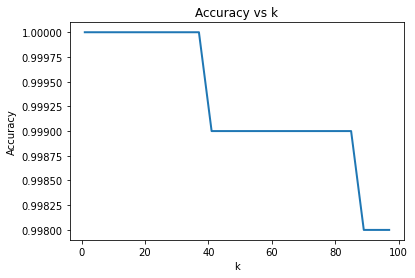

In [15]:
plt.plot(range(k_low, k_high + 1, h), acc, linewidth = 2)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()

## Logistic Regression

In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)

In [41]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def log_reg_model(X, w, predict = False):
    if predict:
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis = -1)
    return sigmoid(np.dot(X, w))

def compute_grad(p, y, X, w, C, r, stochastic = True):
    batch = X.shape[0]
    if stochastic:
        batch = int(X.shape[0]*r)
    X, y, p = resample(X, y, p, n_samples = batch, replace = False)
    return np.dot((p - y), X)/batch + C*w

def compute_loss(p, y, C, w):
    return -(np.dot(y, np.log(p)) + np.dot(1 - y, np.log(1 - p)))/y.shape[0] + (C/2)*np.linalg.norm(w)

def train_log_reg(X_train, y_train, eta = 0.1, tol = 0.05, max_iter = 10000, C = 0, r = 0.3):
    n, p = X_train.shape
    X_bias = np.concatenate([X_train, np.ones((n, 1))], axis = -1)
    w = np.zeros(p + 1) #np.random.random(p + 1)
    p = log_reg_model(X_bias, w)
    loss = compute_loss(p, y_train, C, w)
    iter = 0
    while loss > tol and iter < max_iter:
        w = w - eta*compute_grad(p, y_train, X_bias, w, C, r)
        p = log_reg_model(X_bias, w)
        loss = compute_loss(p, y_train, C, w)
        iter += 1
    return w, loss, iter

In [128]:
w, loss, iter = train_log_reg(X_train_scaled, train_true.to_numpy())
print(w)
print(loss)
print(iter)

[-0.77425735 -4.42913564  0.00550499]
0.18883934197280192
10000


In [129]:
p = log_reg_model(X_dev_scaled, w, predict = True)[:, np.newaxis]
scores_dev = np.concatenate([1 - p, p], axis = -1)
dev_pred = np.argmax(scores_dev, axis = -1)

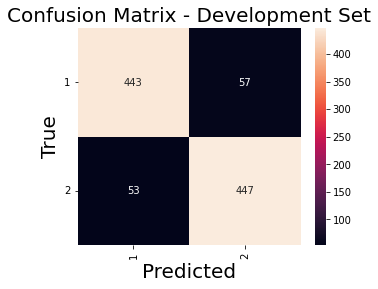

In [130]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [131]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


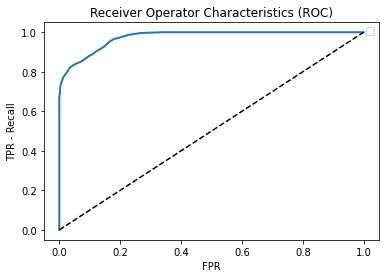

In [132]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

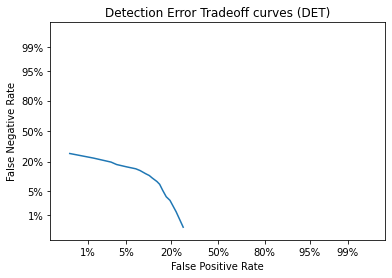

In [133]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()

## PCA

In [142]:
def central_data(x):
    x = x.T
    mu = np.mean(x, axis = -1)[:, np.newaxis]
    return (x - mu)

def pca(z):
    z = central_data(z)
    I, t = z.shape
    cov = np.dot(z, z.T)/t
    lam, w = np.linalg.eig(cov)
    w[:, range(I)] = w[:, sorted(range(I), key = lambda x: -lam[x])]
    return w, sorted(lam, reverse = True)

def pca_transform(X, W, k):
    return np.abs(np.dot(central_data(X).T, W[:, :k]))

In [177]:
k_pca = 1
W, lam = pca(X_train)
X_train_pca = pca_transform(X_train, W, k_pca)
X_dev_pca = pca_transform(X_dev, W, k_pca)

In [146]:
scores_dev = knn_predict(X_train_pca, y_train, X_dev_pca, classes, k = 1)

In [147]:
dev_pred = np.argmax(scores_dev, axis = -1)

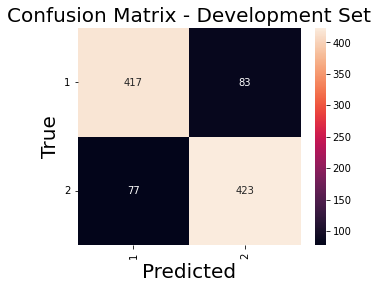

In [148]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [149]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


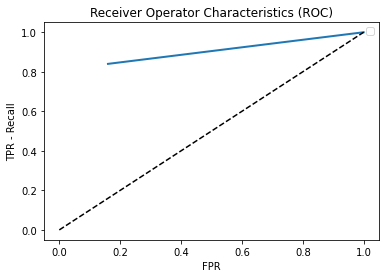

In [150]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

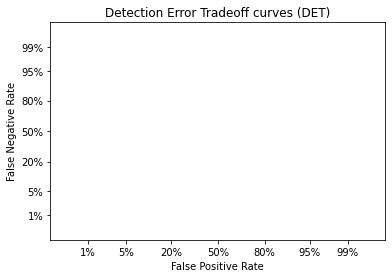

In [151]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()

In [152]:
acc = []
k_low = 1
k_high = 100
h = 4
for k in range(k_low, k_high + 1, h):
    scores_dev = knn_predict(X_train_pca, y_train, X_dev_pca, classes, k = k)
    dev_pred = np.argmax(scores_dev, axis = -1)
    acc.append(accuracy_score(dev_true, dev_pred))

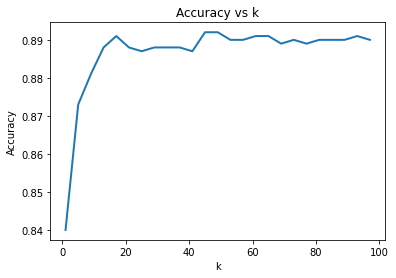

In [153]:
plt.plot(range(k_low, k_high + 1, h), acc, linewidth = 2)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()

### Logistic Regression

In [178]:
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_dev_pca = scaler.transform(X_dev_pca)

In [179]:
w, loss, iter = train_log_reg(X_train_pca, train_true.to_numpy())
print(w)
print(loss)
print(iter)

[ 3.67487519e+00 -2.47143822e-03]
0.25944613754170615
10000


In [180]:
p = log_reg_model(X_dev_pca, w, predict = True)[:, np.newaxis]
scores_dev = np.concatenate([1 - p, p], axis = -1)
dev_pred = np.argmax(scores_dev, axis = -1)

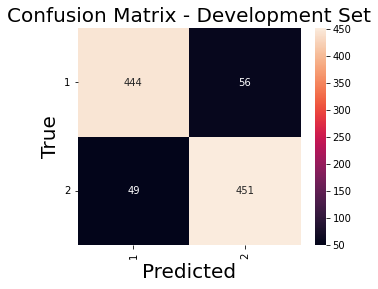

In [181]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [182]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


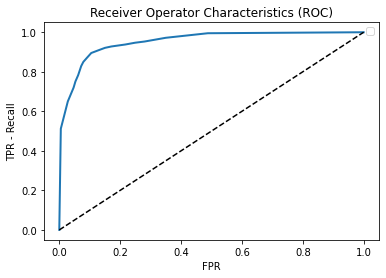

In [183]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

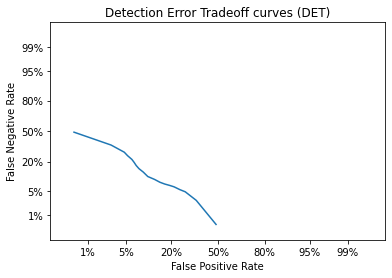

In [184]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()

## LDA

In [35]:
def central_data(x):
    x = x.T
    mu = np.mean(x, axis = -1)[:, np.newaxis]
    return (x - mu)

def class_split(X, y, classes):
    data = np.concatenate([X, y[:, np.newaxis]], axis = -1)
    data = pd.DataFrame(data)
    data_class = []
    for c in classes:
        data_class.append(np.array(data[data[X.shape[-1]] == c]))
    return data_class

def lda(X_train, y_train, classes):   
    _, p = X_train.shape
    data_class = class_split(X_train, y_train, classes) 
    Sw = np.zeros((p, p))
    for data in data_class:
        data_center = central_data(data[:, :-1])
        Sw += np.dot(data_center, data_center.T)
    X_train_center = central_data(X_train)
    St = np.dot(X_train_center, X_train_center.T)
    Sb = St - Sw
    T = np.dot(np.linalg.inv(Sw), Sb)
    lam, w = np.linalg.eig(T)
    b = [i for i in range(len(lam)) if not np.imag(lam[i])]
    w = w[:, b]
    lam = lam[b]
    w[:, range(len(b))] = w[:, sorted(range(len(b)), key = lambda x: -lam[x])]
    return w, sorted(lam, reverse = True)

In [36]:
n_components = len(classes) - 1
W, lam = lda(X_train, y_train, classes)

In [37]:
X_train_lda = np.abs(np.dot(X_train, W[:, :n_components]))
X_dev_lda = np.abs(np.dot(X_dev, W[:, :n_components]))

In [42]:
scores_dev = knn_predict(X_train_lda, y_train, X_dev_lda, classes, k = 1)

In [43]:
dev_pred = np.argmax(scores_dev, axis = -1)

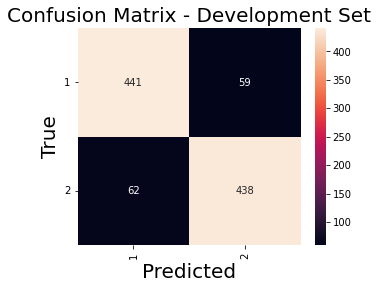

In [44]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [45]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


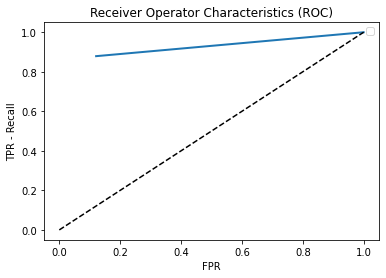

In [46]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

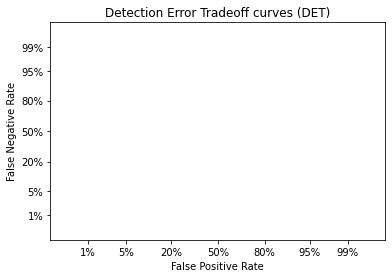

In [47]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()

In [48]:
acc = []
k_low = 1
k_high = 100
h = 4
for k in range(k_low, k_high + 1, h):
    scores_dev = knn_predict(X_train_lda, y_train, X_dev_lda, classes, k = k)
    dev_pred = np.argmax(scores_dev, axis = -1)
    acc.append(accuracy_score(dev_true, dev_pred))

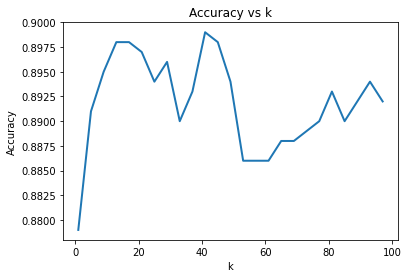

In [49]:
plt.plot(range(k_low, k_high + 1, h), acc, linewidth = 2)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()

### Logistic Regression

In [52]:
scaler = StandardScaler()
X_train_lda = scaler.fit_transform(X_train_lda)
X_dev_lda = scaler.transform(X_dev_lda)

In [53]:
w, loss, iter = train_log_reg(X_train_lda, train_true.to_numpy())
print(w)
print(loss)
print(iter)

[4.75340227 0.01359334]
0.18891155397545467
10000


In [55]:
p = log_reg_model(X_dev_lda, w, predict = True)[:, np.newaxis]
scores_dev = np.concatenate([1 - p, p], axis = -1)
dev_pred = np.argmax(scores_dev, axis = -1)

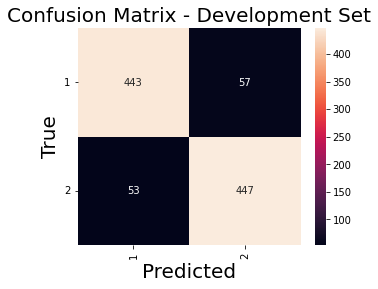

In [56]:
plot_confusion_matrix(dev_true, dev_pred, classes)

In [57]:
tpr, fpr_1, _ = compute_ROC(dev_true, scores_dev)
fpr, fnr, _ = compute_DET(dev_true, scores_dev)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


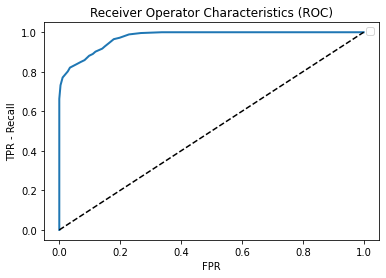

In [58]:
plt.plot(fpr_1, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

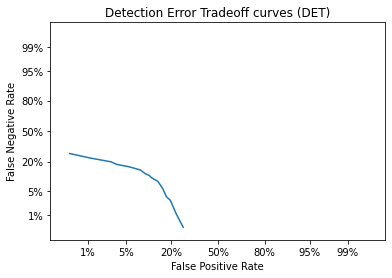

In [59]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()